In [1]:
import coco_dataset
import pathlib
import show_utils
import common
import model as mdl
import torch
import torch.nn as nn
from torchvision.transforms import v2

In [2]:
coco_dataset = coco_dataset.CocoKeypoints(
    root=str(pathlib.Path("../coco") / "images" / "val2017"),
    annFile=str(pathlib.Path("../coco") / "annotations" / "annotations" / "person_keypoints_val2017.json"),
    transform=None)

loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [4]:
saved = "saved.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(mdl.openpose()).to(device)
model.to(device)

if torch.cuda.is_available():
    model.load_state_dict(torch.load(saved))
else:
    model.load_state_dict(torch.load(saved, map_location=torch.device('cpu')))
model.eval();

In [5]:
i = 9

sample: 9
(640, 480)


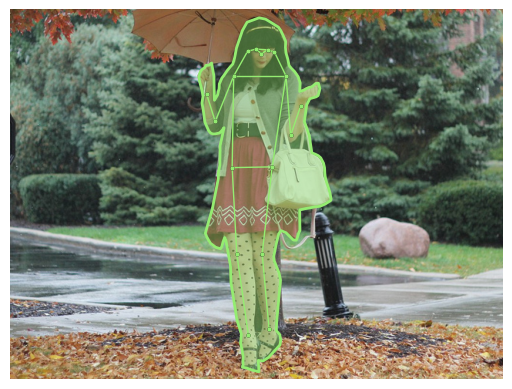

In [6]:
inp, pafs, heatmaps, id, paf_locs, anns = coco_dataset[i]  

show_utils.show_coco(anns[0], anns[1], coco_dataset.coco, draw_bbox=False)

pred_pafs, pred_heatmaps, _, _ = model(inp.unsqueeze_(0).to(device))

print(f"sample: {i}")
print(anns[0].size)
i += 1

detected humans: 1


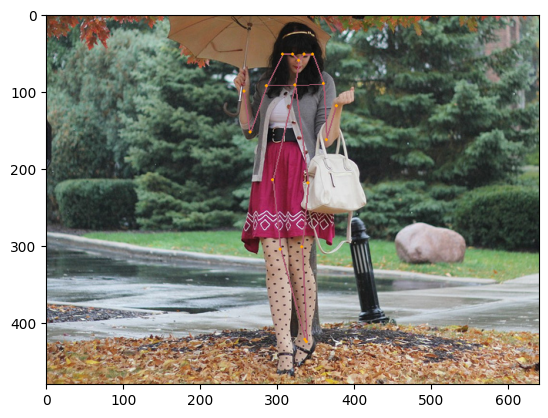

In [7]:
import post
inp = v2.ToPILImage()(inp.squeeze_(0).cpu())
with torch.no_grad():
    humans = post.post_process(pred_heatmaps.squeeze_(0).cpu(), pred_pafs.squeeze_(0).cpu(), inp.size)
    print("detected humans:", len(humans))

if humans:
    formated = post.format(humans)
    show_utils.draw_skeleton(anns[0], formated, connectivity=common.connect_skeleton) 
else:
    print("NO DETECTIONS")

In [8]:
with torch.no_grad():
    pred_heatmaps = pred_heatmaps.squeeze_(0).cpu().numpy()
    pred_pafs = pred_pafs.squeeze_(0).cpu().numpy()

In [9]:
# #---------heatmaps---------
# print(f"Heatmaps.size = {pred_heatmaps.shape}")
# show_utils.plot_grid(pred_heatmaps, 2, 10, (17,4))

# #---------pafs---------
# print(f"Pafs.size = {pred_pafs.shape}")
# show_utils.plot_grid(pred_pafs[[x for x in range(len(pred_pafs)) if x%2==0]], 1, 17, (17, 2))
# show_utils.plot_grid(pred_pafs[[x for x in range(len(pred_pafs)) if x%2==1]], 1, 17, (17, 2))

# # ---------blend---------
# var = pred_pafs[[x for x in range(len(pred_pafs)) if x%2==0]]
# paf_locs = var / (var + 1e-5)
# show_utils.blend(paf_locs, anns[0], rows=7, cols=3, figsize=(15, 30))
# show_utils.blend(pred_heatmaps, anns[0], rows=7, cols=3, figsize=(15, 30))

# # ---------surface---------
# show_utils.surface(pred_pafs[17])

# #---------quiver---------
# show_utils.pafs_quiver_combined(pred_pafs, size=(46,46))
# show_utils.pafs_quiver(pred_pafs, size=(46,46))